## Data

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
from nltk.corpus import stopwords

from config import BASE_DIR
from notebooks.constants import NOT_HEB_BOOKS
from notebooks.text_processing import generate_corpus_df, add_sectarian_label, convert_df_to_by_book
from notebooks.text_processing import pre_process_corpus
from notebooks.notebooks_utils import generate_composition_to_book

matplotlib.rcParams['figure.figsize'] = (15, 10)


**Conditions**
1. Books greater then 300 words.
2. Hebrew books.
3. Each book divided into 100 words chunks.

So we have 202 scrolls that match our criteria (with 39 compositions).
Only 129 scrolls have composition label.

In [2]:
DATA_PATH = "data/text_and_starr_features_22_05_2024.csv"
df = pd.read_csv(DATA_PATH)
df = add_sectarian_label(df)

# Merge with the composition-to-book mapping and remove duplicates
composition_to_book = generate_composition_to_book().drop_duplicates(subset=['book'])
df = pd.merge(df, composition_to_book, on="book", how="left", validate="many_to_one")

# Filter out non-Hebrew books
df = df[~df["book"].isin(NOT_HEB_BOOKS)]

# Aggregate text by book
df_grouped = df.groupby("book")["text"].apply(' '.join).reset_index()

# Merge with additional book info and remove duplicates
book_info = df[["book", "composition", "section"]].drop_duplicates()
df_by_book = pd.merge(df_grouped, book_info, on="book", how="inner")

# Compute the number of words in each book
df_by_book["number_of_words"] = df_by_book['text'].str.split().apply(len)

# Filter books with at least 300 words
df_by_book = df_by_book[df_by_book["number_of_words"] >= 300]

# Get the list of books with enough words
books_with_enough_words = df_by_book["book"].tolist()

# Filter the original dataframe to keep only books with enough words
df_final = df[df["book"].isin(books_with_enough_words)]
df_final.to_csv("data/text_and_starr_features_filtered_data_22_05_2024.csv", index=False)
# Display the final dataframe
print(df_final.info())
df


<class 'pandas.core.frame.DataFrame'>
Index: 2991 entries, 0 to 4442
Data columns (total 25 columns):
 #   Column                                                              Non-Null Count  Dtype  
---  ------                                                              --------------  -----  
 0   book                                                                2991 non-null   object 
 1   sentence_path                                                       2991 non-null   object 
 2   text_lex                                                            2982 non-null   object 
 3   text                                                                2991 non-null   object 
 4   n_words_lex                                                         2991 non-null   int64  
 5   n_words                                                             2991 non-null   int64  
 6   construct to absolute nouns ratio                                   2991 non-null   float64
 7   construct nouns and 

,book,sentence_path,text_lex,text,n_words_lex,n_words,construct to absolute nouns ratio,construct nouns and adjectives percentage,noun to verb ratio,definite_article_percentage,...,aCr percentage,oM percentage,kya percentage,all conjunctions percentage,non-finite to finite verbs ratio,passive verb forms percentage,total word count,section,scroll,composition
0,CD,CD:1:1-1:12,שמע כל ידע צדק בין מעה אל ריב ל כל בר משפט עה ...,ועתה שמעו כל יודעי צדק ובינו במעשי אל כי ריב ל...,82,92,0.666667,0.110092,2.250000,0.917431,...,0.0,0.0,0.0,21.100917,0.333333,0.000000,109.0,sectarian_texts,CD,CD
1,CD,CD:1:12-2:1,אחרון עה דור אחרון עדה בגד הם סור דרך היא עת ה...,אחרונים את אשר עשה בדור אחרון בעדת בוגדים הם ס...,85,96,0.545455,0.114286,1.241379,4.761905,...,0.0,0.0,0.0,14.285714,0.705882,0.000000,105.0,sectarian_texts,CD,CD
2,CD,CD:2:1-2:10,כל המון מעה נדה פנה שמע אל כל בוא ברית גלה אזן...,את כל המונם ומעשיהם לנדה לפניו ועתה שמעו אלי כ...,79,94,0.481481,0.130841,2.222222,0.934579,...,0.0,0.0,0.0,17.757009,0.800000,1.869159,107.0,sectarian_texts,CD,CD
3,CD,CD:2:10-2:20,כל שנה עולם כל קום ל קריא שם יתר פליטה ארץ מלא...,לכל שני עולם ובכולם הקים לו קריאי שם למען התיר...,79,94,1.250000,0.205607,1.714286,0.934579,...,0.0,0.0,0.0,17.757009,0.615385,1.869159,107.0,sectarian_texts,CD,CD
4,CD,CD:2:20-3:8,בר היה חרבה גוע היה היה עה רצון שמר מצוה עה חר...,בשר אשר היה בחרבה כי גוע ויהיו כלא היו בעשותם ...,81,95,1.100000,0.103774,1.000000,1.886792,...,0.0,0.0,0.0,18.867925,0.217391,6.603774,106.0,sectarian_texts,CD,CD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4445,Arugleviticus,Arugleviticus:fB+Cii:14-fB+Cii:16,מות נכה נפש בהמה שלם נפש תחת נפש,יומת ומכה נפש בהמה ישלמנה נפש תחת נפש,9,9,0.500000,0.083333,2.500000,0.000000,...,0.0,0.0,0.0,8.333333,1.000000,8.333333,12.0,NaN,NaN,NaN
4446,Xjoshua,Xjoshua:1:1-2:9,צוה חזק אמץ ערץ חתת עם יהוה אלהים כל הלך צוה י...,הלוא צויתיך חזק ואמץ אל תערץ ואל תחת כי עמך יה...,62,78,1.333333,0.044944,1.045455,13.483146,...,0.0,0.0,0.0,15.730337,0.466667,1.123596,89.0,NaN,NaN,NaN
4447,Xjudges,Xjudges:f1:1-f3_7i:5,הלך יהודה כנעני ישב חברון שם חברון פנה קרית אר...,וילך יהודה אל הכנעני הישב בחברון ושם חברון לפנ...,80,93,-1.000000,0.074074,1.791667,7.407407,...,0.0,0.0,0.0,23.148148,0.200000,0.000000,108.0,NaN,NaN,NaN
4448,Xjudges,Xjudges:f3_7i:5-f3_7ii:1,משך הר תבור לקח עם ערה אלף איש בן נפתלי בן זבו...,ומשכת בהר תבור ולקחת עמך עשרת אלפים איש מבני נ...,42,54,6.000000,0.093750,1.333333,1.562500,...,0.0,0.0,0.0,21.875000,0.090909,0.000000,64.0,NaN,NaN,NaN


## Most correlated scrolls

### Similarity between scrolls

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
import Levenshtein
import numpy as np
from scipy.stats import spearmanr
from tqdm.notebook import tqdm
from transformers import AutoTokenizer, AutoModel
import torch

def plot_heatmap(similarity_df, vectorizer_type, similarity_metric):
    similarity_sums = similarity_df.sum(axis=1)
    sorted_books = similarity_sums.sort_values(ascending=True).index
    
    sorted_similarity_df = similarity_df.loc[sorted_books, sorted_books]
    
    # Plot the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(sorted_similarity_df, cmap='coolwarm', linewidths=.5, annot=False)
    plt.title('Sorted Book Similarity Heatmap (vectorizer: {}, similarity: {})'.format(vectorizer_type, similarity_metric))
    plt.show()

def compute_similarity(df, text_column='text', book_column='book', vectorizer_type='tfidf', similarity_metric='cosine', to_plot=False):
    
    if vectorizer_type == 'tfidf':
        vectorizer = TfidfVectorizer()
        tfidf_matrix = vectorizer.fit_transform(df[text_column])
    elif vectorizer_type == 'trigram':
        vectorizer = CountVectorizer(ngram_range=(3, 3), analyzer='char')
        tfidf_matrix = vectorizer.fit_transform(df[text_column])
    elif vectorizer_type == 'bert':
        tokenizer = AutoTokenizer.from_pretrained('onlplab/alephbert-base')
        model = AutoModel.from_pretrained('onlplab/alephbert-base')
        
        def bert_embed(texts):
            inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=512)
            with torch.no_grad():
                outputs = model(**inputs)
            embeddings = outputs.last_hidden_state.mean(dim=1)
            return embeddings.cpu().numpy()
        
        tfidf_matrix = bert_embed(df[text_column].tolist())
    else:
        raise ValueError("Unsupported vectorizer type. Use 'tfidf', 'count', or 'bert'.")
    
    # Calculate similarity matrix
    if similarity_metric == 'cosine':
        similarity_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)
    elif similarity_metric == 'euclidean':
        similarity_matrix = euclidean_distances(tfidf_matrix, tfidf_matrix)
        similarity_matrix = np.max(similarity_matrix) - similarity_matrix  # Convert to similarity
    elif similarity_metric == 'levenshtein':
        n = len(df)
        similarity_matrix = np.zeros((n, n))
        for i in tqdm(range(n), desc="levenshtein"):
            for j in range(n):
                if i != j:
                    similarity_matrix[i, j] = Levenshtein.distance(df.iloc[i][text_column], df.iloc[j][text_column])
        similarity_matrix = np.max(similarity_matrix) - similarity_matrix
    elif similarity_metric == 'spearman':
        tfidf_array = tfidf_matrix.toarray() if vectorizer_type != 'bert' else tfidf_matrix
        n = len(df)
        similarity_matrix = np.zeros((n, n))
        for i in range(n):
            for j in range(n):
                if i != j:
                    corr, _ = spearmanr(tfidf_array[i], tfidf_array[j])
                    similarity_matrix[i, j] = corr
    else:
        raise ValueError("Unsupported similarity metric. Use 'cosine', 'euclidean', 'levenshtein', or 'spearman'.")
    
    np.fill_diagonal(similarity_matrix, 0)

    # Normalize the similarity matrix
    if similarity_metric in ['cosine', 'spearman']:
        normalized_similarity_matrix = similarity_matrix  # These metrics are already between -1 and 1
    else:
        normalized_similarity_matrix = (similarity_matrix - np.mean(similarity_matrix[similarity_matrix != 0])) / np.std(similarity_matrix[similarity_matrix != 0])
    
    # Create a DataFrame for the similarity matrix
    similarity_df = pd.DataFrame(normalized_similarity_matrix, index=df[book_column], columns=df[book_column])
    
    if to_plot:
        plot_heatmap(similarity_df, vectorizer_type, similarity_metric)
        
    return similarity_df

def save_similarity_matrices(df, vectorizer_types:list, similarity_metrics:list, text_column='text', book_column='book'):
    similarity_matrices = {}
    
    for vectorizer in tqdm(vectorizer_types, desc="Vectorizers"):
        for metric in tqdm(similarity_metrics, desc="Metrics", leave=False):
            similarity_df = compute_similarity(df, text_column, book_column, vectorizer, metric)
            similarity_matrices[f'{vectorizer}_{metric}'] = similarity_df
    
    return similarity_matrices

def analyze_matrices(similarity_matrices):
    matrix_values = np.array([matrix.values for matrix in similarity_matrices.values()])
    mean_matrix = np.mean(matrix_values, axis=0)
    std_matrix = np.std(matrix_values, axis=0)
    
    sample_matrix = list(similarity_matrices.values())[0]
    mean_df = pd.DataFrame(mean_matrix, index=sample_matrix.index, columns=sample_matrix.columns)
    std_df = pd.DataFrame(std_matrix, index=sample_matrix.index, columns=sample_matrix.columns)
    
    significant_correlations = []
    for i in range(mean_df.shape[0]):
        for j in range(i+1, mean_df.shape[1]):
            mean_value = mean_df.iloc[i, j]
            std_value = std_df.iloc[i, j]
            z_value = mean_value / std_value if std_value != 0 else 0
            p_value = 1 - np.abs(z_value)
            significant_correlations.append((mean_df.index[i], mean_df.columns[j], mean_value, std_value, z_value, p_value))
    
    return mean_df, std_df, significant_correlations





In [8]:
# This code is taking a list of vectorizers, a list of similarity metrics, for each one compute the corresponding similiarity matrix and normalize the results. Than im taking the results, generating p-value for each scroll scroll similarity metric.
# This is not a good idea because the each similarity metric have different scales, yielding very different results. The more robust way to do it, is with cross validation.

vectorizer_types = ['tfidf', 'trigram', 
                    # 'bert'
                    ]
similarity_metrics = ['cosine', 
                      # 'euclidean', 'levenshtein', 
                      'spearman'
                      ]

similarity_matrices = save_similarity_matrices(df_by_book.sort_values(by="number_of_words",ascending=False),vectorizer_types, similarity_metrics, text_column='text', book_column='book')
mean_df, std_df, significant_correlations = analyze_matrices(similarity_matrices)
corr_stats = pd.DataFrame(significant_correlations, columns=["book1","book2","mean", "std_", "z_value","p_value"])

most_correlated_books = corr_stats[(np.abs(corr_stats["p_value"])<=0.2) & (corr_stats["mean"]>=corr_stats["mean"].quantile(0.5))].sort_values(by="mean", ascending=False)
most_correlated_books

,book1,book2,mean,std_,z_value,p_value
1718,1QM,4Q397,0.311323,0.264186,1.178424,-0.178424
7043,4Q491,4Q397,0.305227,0.255978,1.192397,-0.192397
146,1Qisaa,4Q397,0.300683,0.254409,1.181889,-0.181889
7013,4Q491,4Q385a,0.292043,0.243386,1.199916,-0.199916
8318,4Q55,4Q429,0.290412,0.242313,1.198499,-0.198499
17295,4Q73,4Q387,0.284187,0.236919,1.199512,-0.199512
552,11Q19,4Q429,0.282455,0.238351,1.185035,-0.185035
6313,4Q511,4Q59,0.280771,0.235456,1.192456,-0.192456
3956,4Q57,4Q397,0.276532,0.236360,1.169963,-0.169963
3226,4Q56,4Q397,0.275648,0.234619,1.174877,-0.174877


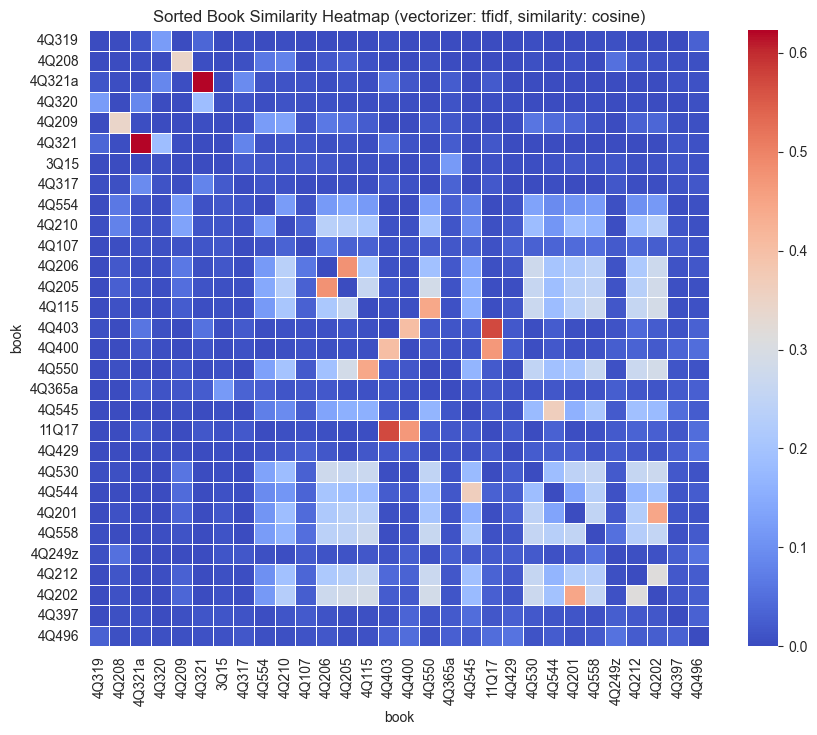

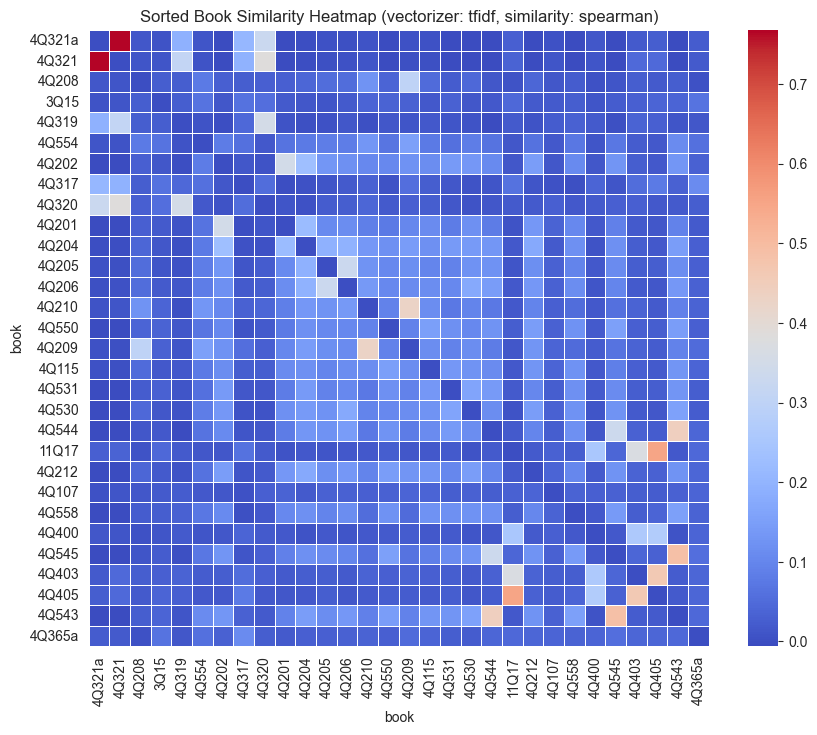

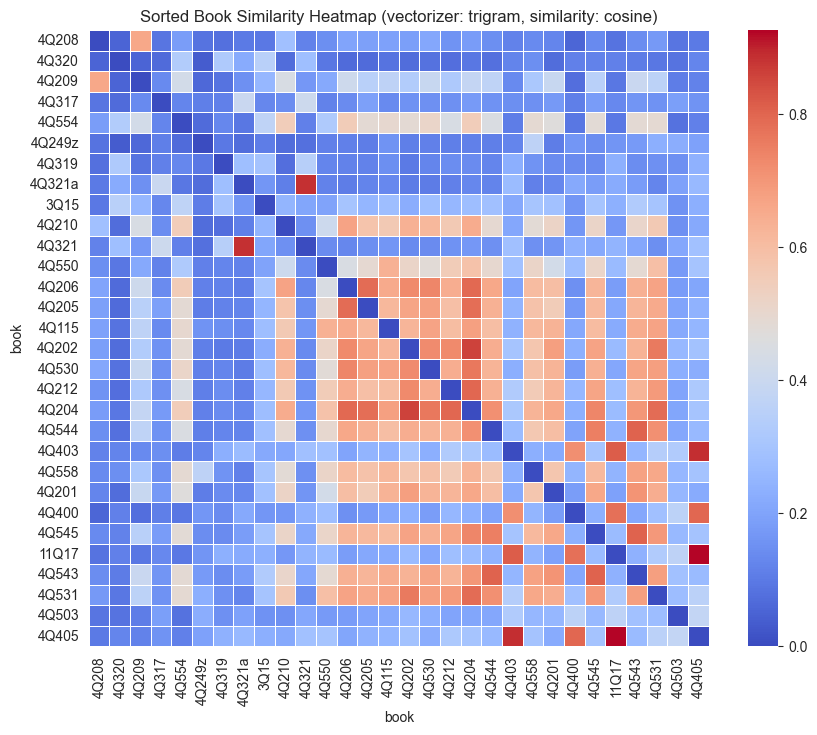

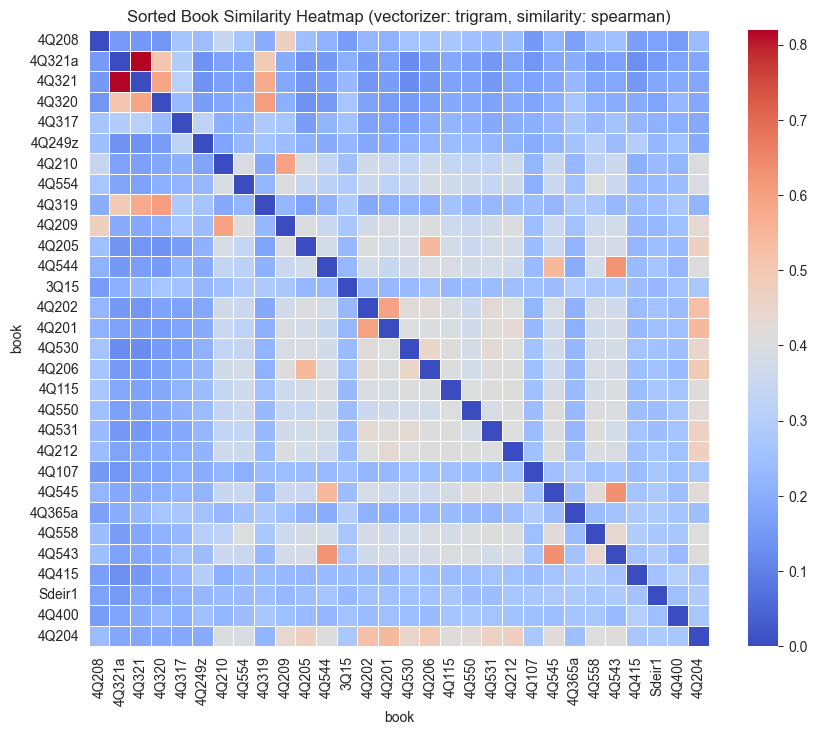

In [12]:
def plot_heatmap(similarity_df, vectorizer_type, similarity_metric, top_n=30):
    similarity_sums = similarity_df.sum(axis=1)
    sorted_books = similarity_sums.sort_values(ascending=True).index
    
    sorted_similarity_df = similarity_df.loc[sorted_books, sorted_books].iloc[:top_n,:top_n]
    
    # Plot the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(sorted_similarity_df, cmap='coolwarm', linewidths=.5, annot=False)
    plt.title('Sorted Book Similarity Heatmap (vectorizer: {}, similarity: {})'.format(vectorizer_type, similarity_metric))
    plt.show()

for run in similarity_matrices.keys():
    plot_heatmap(similarity_matrices[run], vectorizer_type=run.split("_")[0], similarity_metric=run.split("_")[1],top_n=30)

In [144]:
similarity_matrices.keys()
    

dict_keys(['tfidf_cosine', 'tfidf_spearman', 'count_cosine', 'count_spearman'])

In [216]:
tmp = similarity_matrices["count_cosine"]
stacked_df = tmp[tmp>0.75].stack().sort_values(ascending=False).head(6)
pairs = stacked_df.index.to_list()
sorted_tuples = [tuple(sorted(t)) for t in pairs]
unique_tuples = set(sorted_tuples)
unique_tuples_list = list(unique_tuples)
unique_tuples_list

[('4Q82', 'Mur88'), ('4Q11', '4Q22'), ('Mur4', 'Xhev/se5')]

In [243]:
from tqdm.notebook import tqdm
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from difflib import SequenceMatcher
import re


# Function to create windows of a given size
def create_windows(tokens, window_size=10):
    return [tokens[i:i + window_size] for i in range(len(tokens) - window_size + 1)]

def is_similar(window1, window2, threshold=0.99):
    return SequenceMatcher(None, ' '.join(window1), ' '.join(window2)).ratio() > threshold
# Function to merge overlapping or consecutive positions
def merge_positions(positions, window_size=10):
    if not positions:
        return []
    positions = sorted(positions)
    merged = []
    start, end = positions[0], positions[0] + window_size
    for pos in positions[1:]:
        if pos <= end:
            end = max(end, pos + window_size)
        else:
            merged.append((start, end))
            start, end = pos, pos + window_size
    merged.append((start, end))
    return merged

# Function to highlight text segments
def highlight_text(text, merged_positions):
    highlighted_text = text
    offset = 0
    
    for start, end in merged_positions:
        window = ' '.join(word_tokenize(text)[start:end])
        highlighted_window = f"<mark>{window}</mark>"
        pattern = re.escape(window)
        
        start_idx = highlighted_text.find(window, offset)
        if start_idx != -1:
            end_idx = start_idx + len(window)
            highlighted_text = highlighted_text[:start_idx] + highlighted_window + highlighted_text[end_idx:]
            offset = start_idx + len(highlighted_window)
    
    return highlighted_text

# Get positions to highlight in the original texts

def print_similiarity_by_sequence(df_by_book, book1, book2, window_size, similarity_ratio, only_first_words=None):
        """
    Compare two texts from a dataframe, find similar segments, and highlight them.

    Parameters:
    df_by_book (pd.DataFrame): DataFrame containing the texts to be compared.
    book1 (str): Identifier for the first text.
    book2 (str): Identifier for the second text.
    window_size (int): Size of the window (number of words) to be used for comparison.
    similarity_ratio (float): Threshold for similarity ratio to consider two segments as similar.
    only_first_words (int, optional): Limit the comparison to the first 'only_first_words' words of each text.

    Returns:
    str: Highlighted text of the first book.
    str: Highlighted text of the second book.
    """
    text1 = df_by_book[df_by_book["book"]==book1]["text"].to_list()[0]
    text2 = df_by_book[df_by_book["book"]==book2]["text"].to_list()[0]    
    if only_first_words:
        text1 = text1[:only_first_words]
        text2 = text2[:only_first_words]
    print(f"text1 length: {len(text1)}, text2 length: {len(text2)}")
    tokens1 = word_tokenize(text1)
    tokens2 = word_tokenize(text2)
    windows1 = create_windows(tokens1, window_size=window_size)
    windows2 = create_windows(tokens2, window_size=window_size)
    
    similar_windows = []
    for i, window1 in tqdm(enumerate(windows1)):
        for j, window2 in enumerate(windows2):
            if is_similar(window1, window2, similarity_ratio):
                similar_windows.append((i, j, ' '.join(window1), ' '.join(window2)))

    positions1 = [match[0] for match in similar_windows]
    positions2 = [match[1] for match in similar_windows]
    
    # Merge overlapping or consecutive positions
    merged_positions1 = merge_positions(positions1)
    merged_positions2 = merge_positions(positions2)
    
    print(f"{merged_positions1=}, {merged_positions2=}")
    # Highlight the merged segments in the original texts
    highlighted_text1 = highlight_text(text1, merged_positions1)
    highlighted_text2 = highlight_text(text2, merged_positions2)
    
    return highlighted_text1, highlighted_text2

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/yonatanlou/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [246]:

from IPython.core.display import display, HTML
book1, book2 = "Xhev/se5", "Mur4"
highlighted_text1, highlighted_text2 = print_similiarity_by_sequence(df_by_book, book1, book2, window_size=15, similarity_ratio=0.99, only_first_words=500)
display(HTML(f"<h2>Highlighted Text 1:</h2><p>{highlighted_text1}</p>"))
display(HTML(f"<h2>Highlighted Text 2:</h2><p>{highlighted_text2}</p>"))

text1 length: 500, text2 length: 500


/var/folders/yv/8bscwg3x6m5934xb_mry4d_m0000gr/T/ipykernel_2185/536003089.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


0it [00:00, ?it/s]

merged_positions1=[(14, 39), (61, 82)], merged_positions2=[(16, 41), (60, 81)]


In [212]:
from tqdm.notebook import tqdm
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from difflib import SequenceMatcher
pairs = stacked_df.index.to_list()
sorted_tuples = [tuple(sorted(t)) for t in pairs]
unique_tuples = set(sorted_tuples)
unique_tuples_list = list(unique_tuples)


    

text1 = df_by_book[df_by_book["book"]=="Xhev/se5"]["text"].to_list()[0][:150]
text2 = df_by_book[df_by_book["book"]=="Mur4"]["text"].to_list()[0][:150]
# text1 = "Xhev/se5"
# text2 = "Mur4"
# Tokenize the texts into words
tokens1 = word_tokenize(text1)
tokens2 = word_tokenize(text2)

# Function to create windows of a given size
def create_windows(tokens, window_size=10):
    return [tokens[i:i + window_size] for i in range(len(tokens) - window_size + 1)]

# Create windows of 10 words for each text
windows1 = create_windows(tokens1, window_size=15)
windows2 = create_windows(tokens2, window_size=15)

# Function to check similarity between two windows
def is_similar(window1, window2, threshold=0.99):
    return SequenceMatcher(None, ' '.join(window1), ' '.join(window2)).ratio() > threshold

# Find similar windows
similar_windows = []

for i, window1 in tqdm(enumerate(windows1)):
    for j, window2 in enumerate(windows2):
        if is_similar(window1, window2):
            similar_windows.append((i, j, ' '.join(window1), ' '.join(window2)))

# Print the similar windows
for match in similar_windows:
    i, j, window1, window2 = match
    print(f"Text1 (index {i}): {window1}")
    print(f"Text2 (index {j}): {window2}")
    print("")



[nltk_data] Downloading package punkt to
[nltk_data]     /Users/yonatanlou/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


0it [00:00, ?it/s]

Text1 (index 14): לי הוא ויאמר משה אל העם זכר את היום הזה אשר יצאתם ממצרים מבית עבדים
Text2 (index 16): לי הוא ויאמר משה אל העם זכור את היום הזה אשר יצאתם ממצרים מבית עבדים

Text1 (index 15): הוא ויאמר משה אל העם זכר את היום הזה אשר יצאתם ממצרים מבית עבדים כי
Text2 (index 17): הוא ויאמר משה אל העם זכור את היום הזה אשר יצאתם ממצרים מבית עבדים כי

Text1 (index 16): ויאמר משה אל העם זכר את היום הזה אשר יצאתם ממצרים מבית עבדים כי בחזק
Text2 (index 18): ויאמר משה אל העם זכור את היום הזה אשר יצאתם ממצרים מבית עבדים כי בחזק


/var/folders/yv/8bscwg3x6m5934xb_mry4d_m0000gr/T/ipykernel_2185/2183031200.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [207]:
highlighted_text2

'וידבר יהוה אל משה לאמר קדש לי כל בכור פטר כל רחם בבני ישראל באדם <mark>ובבהמה לי הוא ויאמר משה אל העם זכור את היום הזה אשר יצאתם ממצרים מבית</mark> <mark>עבדים כי בחזק יד הוציא יהוה אתכם מזה ולא יאכל חמץ היום אתם יצאים בחדש</mark> האביב <mark>והיה כי יביאך יהוה אל ארץ הכנעני והחתי והאמרי והחוי והיבוסי אשר נשבע לאבתיך לתת</mark> <mark>לך ארץ זבת חלב ודבש ועבדת את העבדה הזאת בחדש הזה שבעת ימים תאכל מצת</mark> <mark>וביום השביעי חג ליהוה מצות יאכל את שבעת הימים ולא יראה לך חמץ ולא יראה</mark> לך שאר בכל  גבלך והגדת לבנך ביום ההוא לאמר <mark>בעבור זה עשה יהוה לי בצאתי ממצרים והיה לך לאות על ידך ולזכרון בין עיניך</mark> <mark>למען תהיה תורת יהוה בפיך כי ביד חזקה הוצאך יהוה ממצרים ושמרת את החקה הזאת</mark> <mark>למועדה מימים ימימה והיה כי יבאך יהוה אל ארץ הכנעני כאשר נשבע לך ולאבתיך ונתנה</mark> לך <mark>והעברת כל פטר רחם ליהוה וכל פטר שגר בהמה אשר יהיה לך הזכרים ליהוה וכל</mark> <mark>פטר חמר תפדה בשה ואם לא תפדה וערפתו וכל בכור אדם בבניך תפדה והיה כי</mark> ישאלך בנך מחר לאמר מה זאת ואמרת